In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
#create dependent and independent features
columns=data.columns.tolist()
#filter the columns to remove data that we do not want
columns = [c for c in columns if c not in ["Class"]]
#store the variable that we are predicting
target="Class"
#Define a random state
state=np.random.RandomState(42)
X=data[columns]
Y=data[target]
X_outliers=state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
#print the shapes of X and Y
print(X.shape)
print(Y.shape)
print(X_outliers.shape)

(284807, 30)
(284807,)
(284807, 30)


## Exploratory Data Analysis

In [7]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

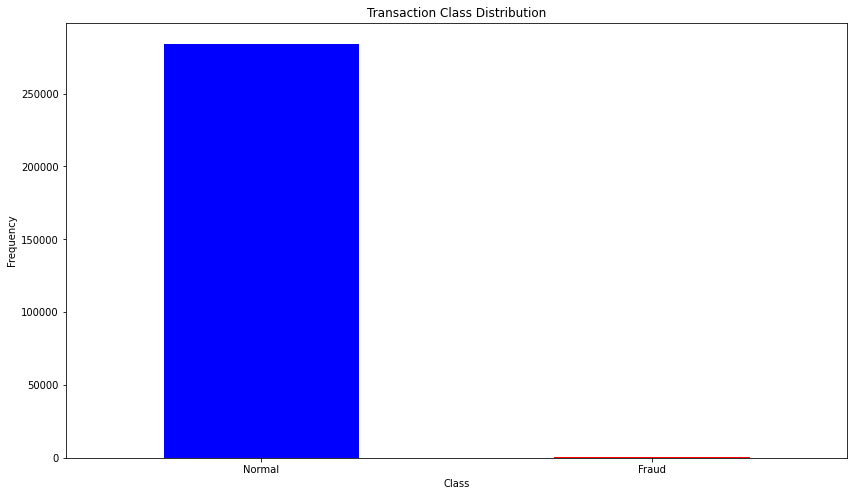

In [8]:
count_classes=pd.value_counts(data['Class'], sort=True)
count_classes.plot(kind='bar',rot=0, color=["blue", "red"])
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [9]:
# Get the fraud and the normal dataset
fraud=data[data['Class']==1]
normal=data[data['Class']==0]

In [10]:
print(fraud.shape, normal.shape)

(492, 31) (284315, 31)


In [11]:
from imblearn.combine import SMOTETomek #combination of undersampling and oversampling lib
from imblearn.under_sampling import NearMiss

In [13]:
#Implementing oversampling for handling imbalanced
smk=SMOTETomek(random_state=42)
X_res,y_res=smk.fit_sample(X,Y)

In [14]:
X_res.shape, y_res.shape

((567562, 30), (567562,))

In [16]:
from collections import Counter
print("Original dataset shape {}".format(Counter(Y)))
print("Resampled dataset shape {}".format(Counter(y_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 283781, 1: 283781})


## Alternate library to use for over sampling

In [37]:
from imblearn.over_sampling import RandomOverSampler

In [38]:
os=RandomOverSampler(1)

/home/ajay/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:635: FutureWarning: Pass sampling_strategy=1 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


In [39]:
X_train_res, y_train_res=os.fit_sample(X,Y)

In [40]:
X_train_res.shape, y_train_res.shape

((568630, 30), (568630,))

In [41]:
print("Original dataset shape {}".format(Counter(Y)))
print("Resampled dataset shape {}".format(Counter(y_train_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 284315, 1: 284315})


In [42]:
# In this example I use SMOTETomek which is a method of imblearn. SMOTETomek is a hybrid method
# which uses an under sampling method (Tomek) in with an over sampling method (SMOTE).
os_us=SMOTETomek(0.5)

X_train_res1,y_train_res1=os_us.fit_sample(X,Y)

/home/ajay/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:635: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


In [43]:
X_train_res1.shape, y_train_res1.shape

((424818, 30), (424818,))

In [ ]:
aaa